# Notebook summary

This case features a time series problem where the aim is to produce a predictive model that can forecast future amounts of purchases. In order to do so we will perform data exploration in this notebook to understand the dataset better. The aim of the exploration is to give us hints which models might be appropriate and to understand which data processing should be done before feeding it into the model. More specifically we will go over the following items: 

- Amount of data

- Missing values

- Visualization

- Trend/seasonality

- Time series analysis

# Import Packages

In [57]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Import Data

In [2]:
df = pd.read_csv("../data/raw/data.csv", sep = ";", parse_dates = ["date"])

In [3]:
df

,date,purchase_amount
0,2010-01-01,83760.18
1,2010-02-01,96292.13
2,2010-03-01,105984.26
3,2010-04-01,109916.18
4,2010-05-01,109057.51
...,...,...
127,2020-08-01,NaN
128,2020-09-01,NaN
129,2020-10-01,NaN
130,2020-11-01,NaN


The data only contains two columns, the date and the purchase amount. In total we have 132 months in the dataset. However, the purchase amount column contains null values for some months. Let's see how many they are. 

# Missing Values

In [4]:
df.isnull().sum()

date                0
purchase_amount    12
dtype: int64

There are 12 months of missing data for purchase amount(the last 12 months). That means in total we have 130 months(samples) to train our model.

# Visualization
The fastest way to get to know the data is through visualization. Let's plot it!

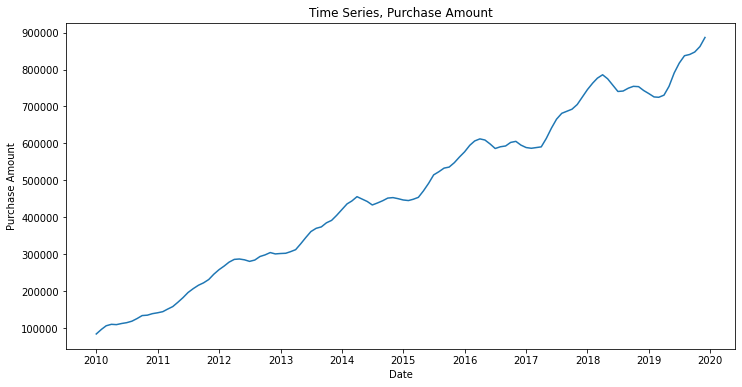

In [5]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(df["date"], df["purchase_amount"])
ax.set_title("Time Series, Purchase Amount")
ax.set_xlabel("Date")
ax.set_ylabel("Purchase Amount")
plt.show()

From the plot it is evident that we are not working with a stationary time series since there is an upward trend. The series also seems to exhibit a cyclical behavior where each cycle is roughly 2 years. 

# Time Series Analysis

It seems a seasonal ARIMA(SARIMA) model could be appropriate for the data. The SARIMA model is defined by the parameters $(p, d, q)\mathrm{x}(P, D, Q, s)$ where 

- p, P are the number of autoregressive(AR) terms.

- d, D are the orders of integration(differencing).

- q, Q number of moving average terms.

- s is the number of observations in a season. 

There are two ways to find a good set of hyperparameters. The first way is through inspection of ACF and PACF plots. However, from experience it is not always the case that you will pick the right set hyperparameters in the sense that the will produce the best out of fold predictions.

Instead we will perform hyperparameter search through bayesian optimization with the Optuna library. This automates the search for the right hyperparameters and it tends to produce better results in less time compared to grid search and random search.

The differencing parameter $d$ is used to transform non-stationary series to stationary ones. Let's start to analyze the stationary of the series.

## Stationarity

We assumed from our previous plot that the time series is non-stationary, we can confirm this with the Augmented Dickey-Fuller Test. The null hypothesis for this test is that the series is non-stationary. We reject this hypothesis if our p-value is less than 0.05.

In [47]:
def adf_test(time_series):
    adf = adfuller(time_series)
    stats = pd.Series(adf[0:4], index = ["Test Statistic","p-value","#Lags Used", "#Observations Used"])
    return stats

In [51]:
adf = adf_test(df["purchase_amount"].dropna())
adf

Test Statistic         -1.909396
p-value                 0.327654
#Lags Used             13.000000
#Observations Used    106.000000
dtype: float64

When we run the statistical test on the raw time series we get a p-value of 0.33. Therefore, we do not reject the hypothesis of non-stationary data. Let's take the first order differences of the series and see if we get different results.

In [53]:
adf = adf_test(df["purchase_amount"].diff(1).dropna())
adf

Test Statistic       -9.493114e+00
p-value               3.608122e-16
#Lags Used            1.300000e+01
#Observations Used    1.050000e+02
dtype: float64

After taking the first order difference we can reject the null hypothesis. Thus, we can expect that setting $d=1$ would be a suitable option.

# Notebook Conclusion

- The data contains 130 samples of monthly purchase amount.

- Since there are few samples in the dataset we will exclude more complex techniques such as deep learning with RNN/LSTM architectures.

- The series is steadily trending upwards.

- The series seems cyclical with a 2 year period.

- The series is nonstationary which can be solved with differencing.